In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal
import librosa
import warnings
warnings.simplefilter('ignore')
import pywt
import IPython.display as ipd

In [2]:
sns.set_style('white')

In [4]:
DATA_DIR = 'data/'

### 換気扇の音が含まれる音声ファイル

In [5]:
data, sr = librosa.load(DATA_DIR+'noisy_voice.wav', sr=None)

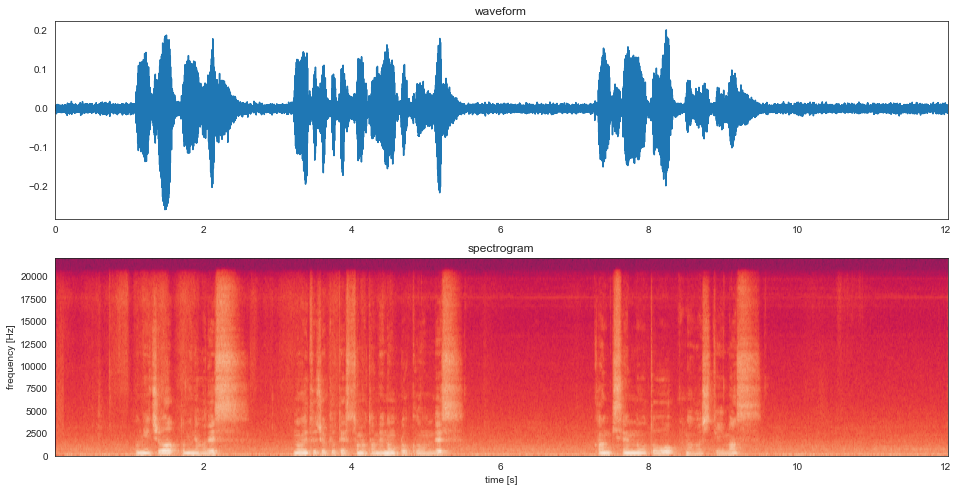

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))
axs = axs.ravel()
xs = np.arange(0, len(data)) / sr
axs[0].plot(xs, data)
axs[0].set_title('waveform')
axs[0].set_xlim(0, len(data)/sr)
axs[1].specgram(data, Fs=sr)
axs[1].set_title('spectrogram')
axs[1].set_xlabel('time [s]')
axs[1].set_ylabel('frequency [Hz]')
fig.show()

ipd.Audio(data, rate=sr)

In [7]:
def compare_plot(origin, denoise, sr=44100):
    xs = np.arange(0, len(origin)) / sr
    fig, axs = plt.subplots(4, 1, figsize=(16, 12))
    axs[0].plot(xs, origin)
    axs[0].set_title('original')
    axs[0].set_xlim(0, len(origin)/sr)
    axs[1].specgram(origin, Fs=sr)
    axs[1].set_title('spectrogram')
    axs[1].set_ylim(0, sr/2)
    axs[1].set_xlabel('time [s]')
    axs[1].set_ylabel('frequency [Hz]')
    axs[2].plot(xs, denoise)
    axs[2].set_title('denoise')
    axs[2].set_xlim(0, len(denoise)/sr)
    axs[3].specgram(denoise, Fs=sr)
    axs[3].set_title('denoise spectrogram')
    axs[3].set_ylim(0, sr/2)
    axs[3].set_xlabel('time [s]')
    axs[3].set_ylabel('frequency [Hz]')
    plt.tight_layout()
    fig.show()

    ipd.display('Before')
    ipd.display(ipd.Audio(origin, rate=sr))
    ipd.display('After')
    ipd.display(ipd.Audio(denoise, rate=sr))

---
### カルマンフィルター

In [12]:
class Kalman:
    def __init__(self, observation, start_position, start_deviation, deviation_true, deviation_noise):
        self.observation = observation
        self.n_obs = len(observation)
        self.start_position = start_position
        self.start_deviation = start_deviation
        self.deviation_true = deviation_true
        self.deviation_noise = deviation_noise
        
        self._fit()
        
    def _forward(self):
        self.x_prev_ = [self.start_position]
        self.P_prev_ = [self.start_deviation]
        self.K_ = [self.P_prev_[0] / (self.P_prev_[0] + self.deviation_noise)]
        self.P_ = [self.deviation_noise * self.P_prev_[0] / (self.P_prev_[0] + self.deviation_noise)]
        self.x_ = [self.x_prev_[0] + self.K_[0] * (self.observation[0] - self.x_prev_[0])]
        
        for t in range(1, self.n_obs):
            self.x_prev_.append(self.x_[t-1])
            self.P_prev_.append(self.P_[t-1] + self.deviation_true)
            self.K_.append(self.P_prev_[t] / (self.P_prev_[t] + self.deviation_noise))
            self.x_.append(self.x_prev_[t] + self.K_[t] * (self.observation[t] - self.x_prev_[t]))
            self.P_.append(self.deviation_noise * self.P_prev_[t] / (self.P_prev_[t] + self.deviation_noise))
    
    def _backward(self):
        self.x_all_ = [self.x_[-1]]
        self.P_all_ = [self.P_[-1]]
        self.C_ = [self.P_[-1] / (self.P_[-1] + self.deviation_true)]
        
        for t in range(2, self.n_obs + 1):
            self.C_.append(self.P_[-t] / self.P_[-t] + self.deviation_true)
            self.x_all_.append(self.x_[-t] + self.C_[-1] * (self.x_all_[-1] - self.x_prev_[-t+1]))
            self.P_all_.append(self.P_[-t] + (self.C_[-1]**2) * (self.P_all_[-1] - self.P_prev_[-t+1]))
        
        self.C_.reverse()
        self.x_all_.reverse()
        self.P_all_.reverse()
    
    def _fit(self):
        self._forward()
        self._backward()

In [33]:
kf = Kalman(data,
            start_position=0,
            start_deviation=10,
            deviation_true=10,
            deviation_noise=100
           ) 

'Before'

'After'

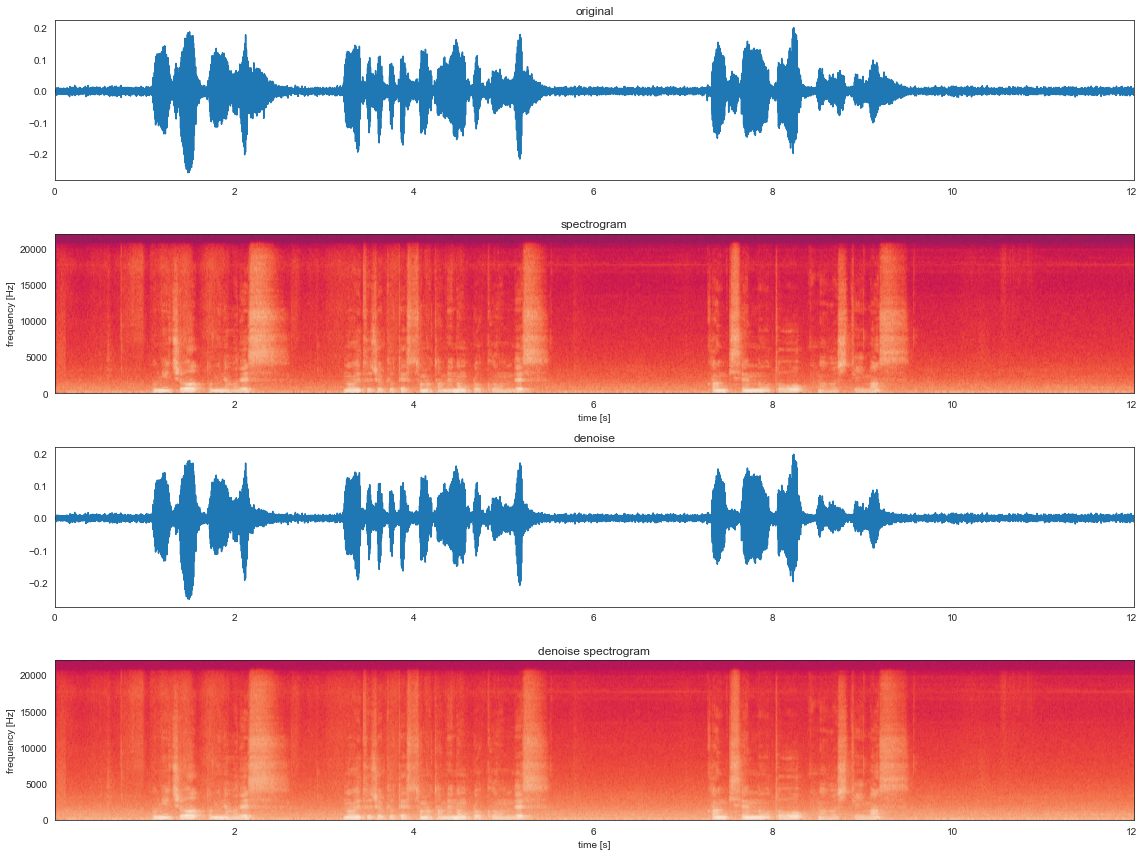

In [34]:
compare_plot(data, kf.x_)